In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import os
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from PIL import Image
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split
import numpy.matlib
import scipy
from efficientnet_pytorch import EfficientNet

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)

# 学習データの作成

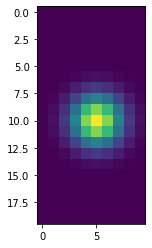

In [3]:
def get_heatmap(h, w, h_center, w_center, sigma=5):
    w_range = np.arange(0,w)-w_center
    w_range = np.matlib.repmat(w_range, h, 1)
    h_range = np.arange(0,h)-h_center
    h_range = h_range.reshape(h,1)
    h_range = np.matlib.repmat(h_range, 1, w)
    Yxyc = np.exp(-(w_range**2+h_range**2)/sigma)
    return Yxyc.T

hm = get_heatmap(10, 20, 5, 10)
plt.imshow(hm)

In [4]:
def line2P(l):
    P_elem = l.split()[1:]
    P = np.array(P_elem, dtype=np.float).reshape(3,-1)
    return P

def readCalib(calib_name, calib_path):
    calib_name = calib_path + calib_name + ".txt"
    with open(calib_name) as f:
        P0 = line2P(f.readline())
        P1 = line2P(f.readline())
        P2 = line2P(f.readline())
        P3 = line2P(f.readline())
        R0_rect = line2P(f.readline())
        Tr_velo_to_cam = line2P(f.readline())
        Tr_imu_to_velo = line2P(f.readline())
    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo

def projectToImage(pts3D, P):
    P = np.array(P)
    
    ones = np.ones([1,pts3D.shape[1]])
    pts3D = np.append(pts3D, ones, axis=0)
    pts2D = np.dot(P, pts3D)
    pts2D[0] /= pts2D[2]
    pts2D[1] /= pts2D[2]
    pts2D = np.delete(pts2D, obj=2, axis=0)
    return pts2D

def selectVisiblePoint(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # left
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # right
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    visible_mask = np.zeros(8)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        if np.dot(c_to_O, normal)>0:
            visible_mask += face_mask[i]
    return visible_mask!=0

def compute3Dbb(obj, P):
    face_idx = np.array([[1,2,6,5], # front face
                         [2,3,7,6], # left face
                         [3,4,8,7], # back face
                         [4,1,5,8]]) # right face
    ry = obj["rotation_y"]
    R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                  [          0, 1,          0],
                  [-np.sin(ry), 0, np.cos(ry)]],
                 dtype=np.float)
    l = obj["length"]
    w = obj["width"]
    h = obj["height"]
    corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                        [0,0,0,0,-h,-h,-h,-h],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                       dtype=np.float).reshape(3,-1)
    corner3D = np.dot(R,corners)
    xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
    corner3D += xyz # 直方体の各頂点のxyz座標
    
    visible_flag = selectVisiblePoint(corner3D) # 見える頂点を判定
    corner2D = projectToImage(corner3D, P) # 画像座標に変換

    return visible_flag, corner2D, face_idx

def getP2(img_name):
    calib_path = "../data/training/calib/"
    _, _, P2, _, _, _, _ = readCalib(img_name, calib_path)
    return P2

def getCorner3D(img_name):
    annotations = annotations_list[annotations_list["img_name"]==img_name]
    _, _, P2, _, _, _, _ = readCalib(img_name, self.calib_path)

    visible_flags, corner3Ds = [], []
    for _, anno in annotations.iterrows():
        visible_flag, corner3D, face_idx = compute3Dbb(anno, P2)
        visible_flags.append(visible_flag)
        corner3Ds.append(corner3D)
    return visible_flags, corner3Ds

In [40]:
RESIZE_SCALE = 4
IMG_WIDTH = 1280 // RESIZE_SCALE
IMG_HEIGHT = IMG_WIDTH // 16 * 5 #400
MODEL_SCALE = 4

def preprocess_image(img, training=False):
    #画像サイズを統一
    img_shape = img.shape[0]//RESIZE_SCALE, img.shape[1]//RESIZE_SCALE
    if training:
        off_x = randint(0, IMG_WIDTH-img_shape[1])
        off_y = randint(0, IMG_HEIGHT-img_shape[0])
    else:
        off_x = np.round((IMG_WIDTH-img_shape[1])/2).astype('int')
        off_y = np.round((IMG_HEIGHT-img_shape[0])/2).astype('int')
    
    img_dummy = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3])
    resize_img = cv2.resize(img, (img_shape[1], img_shape[0]))
    img_dummy[off_y:off_y+img_shape[0], off_x:off_x+img_shape[1]] = resize_img
    return (img_dummy / 255).astype('float32'), (off_x, off_y)

def get_mask_and_regr(img_name, annotations_list, offset=(0,0)):
    
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    mask_cnr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    #height, width
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 2], dtype='float32')
    #x_(flt,flb,frt,frb,blt,blb,brt,brb),y_(flt,flb,frt,frb,blt,blb,brt,brb)
    regr_cnr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 16], dtype='float32')
    
    annotations = annotations_list[annotations_list["img_name"]==img_name]

    P2 = getP2(img_name)
    
    target_type = ['Car', 'Van', 'Truck']

    # annotationを遠い順に並び替え
    annos = []
    for _, anno in annotations.iterrows():
        annos.append(anno)
    annos_sorted = sorted(annos, key=lambda x:x['z'], reverse=True)
    
    for anno in annos_sorted:
        if anno["type"] in target_type:
            ## center pointの学習データを作成 
            # annotationをx, y, width, heightに変換
            x = (anno["left"]+anno["right"])/2 / MODEL_SCALE
            y = (anno["top"]+anno["bottom"])/2 / MODEL_SCALE
            width = (anno["right"]-anno["left"]) / MODEL_SCALE
            height = (anno["bottom"]-anno["top"]) / MODEL_SCALE
            
            x = x / RESIZE_SCALE
            y = y / RESIZE_SCALE
            
            x = x+offset[0]/ MODEL_SCALE
            y = y+offset[1]/ MODEL_SCALE
            
            width = width / RESIZE_SCALE
            height = height / RESIZE_SCALE
            
            w = max(width,1)
            h = max(height,1)
            left = np.round(x-w/2).astype('int')
            top = np.round(y-h/2).astype('int')
            right = np.round(x+w/2).astype('int')
            bottom = np.round(y+h/2).astype('int')
            hm = get_heatmap(right-left, bottom-top, w/2, h/2)

            ## cornerの座標を計算
            vsbl_flg, cnr, _ = compute3Dbb(anno, P2)
            cnr[0] = (cnr[0]/RESIZE_SCALE + offset[0])/MODEL_SCALE
            cnr[1] = (cnr[1]/RESIZE_SCALE + offset[1])/MODEL_SCALE
            
            # 隠れている車両の正解データを消去(maskのみ)
            pts = cv2.convexHull(np.round(cnr).T.astype(np.int32))
            cv2.fillConvexPoly(mask, points=pts, color=0)
            cv2.fillConvexPoly(mask_cnr, points=pts, color=0)

            # x, y, width, heightからmask, regrを作成
            mask[top:bottom, left:right] = hm
            regr[top:bottom, left:right, 0] = height
            regr[top:bottom, left:right, 1] = width
            
            # cornerの位置の学習データ
            # 初期化
            nums = np.arange(0,right-left,1)
            nums = np.tile(nums,8).reshape(8,right-left).T
            nums = np.tile(nums,(bottom-top,1)).reshape(bottom-top,right-left,8)
            regr_cnr[top:bottom, left:right,:8] = nums
            nums = np.arange(0,bottom-top,1)
            nums = np.tile(nums,8).reshape(8,bottom-top).T
            nums = np.tile(nums,right-left).reshape(bottom-top,right-left,8)
            regr_cnr[top:bottom, left:right,8:] = nums
            # coner位置までのx,y方向pixel数
            for i in range(8):
                regr_cnr[top:bottom, left:right,i] -= (cnr[0,i]-left) # xベクトル
                regr_cnr[top:bottom, left:right,i+8] -= (cnr[1,i]-top) # yベクトル

            # cornerの学習データを作成
            cnr = cnr[:,vsbl_flg]
            cnr = np.round(cnr).astype('int')
            if w > 5:
                for i in range(8):
                    try:
                        # コーナーが見えないor画像外だったら何もしない
                        mask_cnr[cnr[1,i],cnr[0,i]] = 1
                    except:
                        pass
    
    return mask, regr, mask_cnr, regr_cnr

In [22]:
def get_img_path(img_name_list):
    for i in range(len(img_name_list)):
        img_name_list[i] = PATH + "image_2/" + img_name_list[i] + ".png"
        return img_name_list

In [23]:
img_name = train_list[2]
img_name_list = get_img_path([img_name])
img = plt.imread(img_name_list[0])
img, offset = preprocess_image(img)
mask, regr, cnr, regr_cnr = get_mask_and_regr(img_name, annotations_list, offset)

### check each loss

In [24]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, annotation, root_dir, training=True):
        self.data_list = data_list
        self.anno = annotation
        self.root_dir = root_dir
        self.training = training
        
        self.anno = pd.read_pickle(ANNOTATIONS)
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data
        img_name = self.data_list[idx]
        img_path = self.root_dir + "image_2/" + img_name + ".png"
        img = plt.imread(img_path)
        img, offset = preprocess_image(img, self.training)
        
        if self.training:
            mask, regr, mask_cnr, regr_cnr = get_mask_and_regr(img_name, self.anno, offset)
            # Augmentation
            fliplr = rand()>.5
            if fliplr:
                img, mask, regr, mask_cnr, regr_cnr = img[:,::-1], mask[:,::-1], regr[:,::-1], mask_cnr[:,::-1], regr_cnr[:,::-1]
                regr_cnr[:,:,:8] *= -1
            fliptb = rand()>.5
            if fliptb:
                img, mask, regr, mask_cnr, regr_cnr = img[::-1], mask[::-1], regr[::-1], mask_cnr[::-1], regr_cnr[::-1]
                regr_cnr[:,:,8:] *= -1
            
            # 配列の向き？を入れ替える
            regr = np.rollaxis(regr, 2, 0)
            regr_cnr = np.rollaxis(regr_cnr, 2, 0)
        img = np.rollaxis(img, 2, 0)
            
        if self.training:
            return [img.copy(), mask.copy(), regr.copy(), mask_cnr.copy(), regr_cnr.copy()]
        else:
            return img

In [122]:
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=False)

In [55]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

In [27]:
lambda_size = 0.1
lambda_offset = 0.1

def criterion(prediction, mask, regr, mask_cnr, regr_cnr):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    # mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:3]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    regr_loss = regr_loss.mean(0)
    
    # mask_corner _loss
    pred_mask_cnr = torch.sigmoid(prediction[:, 3])
    mask_cnr_loss = mask_cnr * torch.log(pred_mask_cnr + 1e-12) + (1 - mask_cnr) * torch.log(1 - pred_mask_cnr + 1e-12)
    mask_cnr_loss = -mask_cnr_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 4:]
    regr_cnr_loss = (torch.abs(pred_regr - regr_cnr).sum(1) * mask).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    regr_cnr_loss = regr_cnr_loss.mean(0)
    
    return mask_loss, lambda_size*regr_loss, mask_cnr_loss, lambda_offset*regr_cnr_loss

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eval_loss():
    train_mask_loss = 0
    train_regr_loss = 0
    train_mask_cnr_loss = 0
    train_regr_cnr_loss = 0
    
    with torch.no_grad():
        for batch_idx, (img_batch, mask_batch, regr_batch, cnr_batch, regr_cnr_batch) in enumerate(tqdm(train_loader)):
                
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)
            cnr_batch = cnr_batch.to(device)
            regr_cnr_batch = regr_cnr_batch.to(device)
            
            output = np.zeros([img_batch.shape[0],20,mask_batch.shape[1],mask_batch.shape[2]])
            output = torch.tensor(output, device=device)
            mask_loss, regr_loss, mask_cnr_loss, regr_cnr_loss =\
                criterion(output, mask_batch, regr_batch, cnr_batch, regr_cnr_batch)
            
            train_mask_loss += mask_loss.detach()
            train_regr_loss += regr_loss.detach()
            train_mask_cnr_loss += mask_cnr_loss.detach()
            train_regr_cnr_loss += regr_cnr_loss.detach()
    
    train_mask_loss /= len(train_list)
    train_regr_loss /= len(train_list)
    train_mask_cnr_loss /= len(train_list)
    train_regr_cnr_loss /= len(train_list)
    train_loss = train_mask_loss + train_regr_loss + train_mask_cnr_loss + train_regr_cnr_loss
    
    print('train_mask_loss : ', train_mask_loss.data.cpu().numpy())
    print('train_regr_loss : ', train_regr_loss.data.cpu().numpy())
    print('train_mask_cnr_loss : ', train_mask_cnr_loss.data.cpu().numpy())
    print('train_regr_cnr_loss : ', train_regr_cnr_loss.data.cpu().numpy())
    print('train_loss : ', train_loss.data.cpu().numpy())

eval_loss()

  2%|▏         | 141/7106 [00:06<05:34, 20.83it/s]


KeyboardInterrupt: 

# helper function

In [28]:
def visualize_mask(img, mask=None, cnr=None):
    mask_red = np.zeros_like(img)
    if not mask is None:
        mask_tmp = cv2.resize(mask, dsize=(img.shape[1],img.shape[0]))
        mask_red[:,:,0] += mask_tmp        
    
    cnr_green = np.zeros_like(img)
    if not cnr is None:
        cnr_tmp = cv2.resize(cnr, dsize=(img.shape[1],img.shape[0]))
        cnr_green[:,:,1] += cnr_tmp
    
    img = img*255 + mask_red + cnr_green
    plt.figure(figsize=((15, 4)))
    plt.imshow(img)
        
    plt.xlim([0,img.shape[1]])
    plt.ylim([img.shape[0],0])

In [76]:
def inference_2D(img, mask, regr, MODEL_SCALE=1):# 検出した車両を抽出
    mask_max = scipy.ndimage.filters.maximum_filter(mask, size=3)
    mask[mask_max!=mask] = 0
    mask[mask<0] = 0
    
    # 検出結果をbounding boxに変換
    y, x = np.nonzero(mask)
    conf = mask[mask!=0]
    h = regr[mask!=0,0]
    w = regr[mask!=0,1]
    
    left = (x - w/2)*MODEL_SCALE
    right = (x + w/2)*MODEL_SCALE
    top = (y - h/2)*MODEL_SCALE
    bottom = (y + h/2)*MODEL_SCALE
    
    # 描画
    plt.figure(figsize=(15, 4))
    plt.imshow(img*255)
    plt.plot([left,right,right,left,left],
             [top,top,bottom,bottom,top],
             color="r",linewidth=1
    )
        
    plt.xlim([0,img.shape[1]])
    plt.ylim([img.shape[0],0])

In [30]:
def inference_3D(img, mask, regr_cnr, MODEL_SCALE=1):# 検出した車両を抽出
    mask_red = np.zeros_like(img)
    if not mask is None:
        mask_tmp = cv2.resize(mask, dsize=(img.shape[1],img.shape[0]))
        mask_red[:,:,0] += mask_tmp        
    
    cnr_green = np.zeros_like(img)
    if not cnr is None:
        cnr_tmp = cv2.resize(cnr, dsize=(img.shape[1],img.shape[0]))
        cnr_green[:,:,1] += cnr_tmp
    
    img = img*255 + mask_red + cnr_green
    
    
    mask_max = scipy.ndimage.filters.maximum_filter(mask, size=3)
    mask[mask_max!=mask] = 0
    mask[mask<0] = 0
    
    # 検出結果をbounding boxに変換
    y, x = np.nonzero(mask)
    conf = mask[mask!=0]
    
    for i in range(8):
        start_x = x*MODEL_SCALE
        start_y = y*MODEL_SCALE
        goal_x = (x + regr_cnr[mask!=0,i])*MODEL_SCALE
        goal_y = (y + regr_cnr[mask!=0,i+8])*MODEL_SCALE
    
    # 描画
    plt.figure(figsize=(15, 4))
    plt.imshow(img)
    for i in range(8):
        start_x = x*MODEL_SCALE
        start_y = y*MODEL_SCALE
        goal_x = (x - regr_cnr[mask!=0,i])*MODEL_SCALE
        goal_y = (y - regr_cnr[mask!=0,i+8])*MODEL_SCALE
        plt.plot((start_x,goal_x),(start_y,goal_y))
        
    plt.xlim([0,img.shape[1]])
    plt.ylim([img.shape[0],0])

In [31]:
def detection_3D(img, mask, regr_cnr, MODEL_SCALE=1):# 検出した車両を抽出
    mask_red = np.zeros_like(img)
    if not mask is None:
        mask_tmp = cv2.resize(mask, dsize=(img.shape[1],img.shape[0]))
        mask_red[:,:,0] += mask_tmp        
    
    cnr_green = np.zeros_like(img)
    if not cnr is None:
        cnr_tmp = cv2.resize(cnr, dsize=(img.shape[1],img.shape[0]))
        cnr_green[:,:,1] += cnr_tmp
    
    img = img*255 + mask_red + cnr_green
    
    
    mask_max = scipy.ndimage.filters.maximum_filter(mask, size=3)
    mask[mask_max!=mask] = 0
    mask[mask<0] = 0
    
    # 検出結果をbounding boxに変換
    y, x = np.nonzero(mask)
    conf = mask[mask!=0]
    
    for i in range(8):
        start_x = x*MODEL_SCALE
        start_y = y*MODEL_SCALE
        goal_x = (x + regr_cnr[mask!=0,i])*MODEL_SCALE
        goal_y = (y + regr_cnr[mask!=0,i+8])*MODEL_SCALE
    
    # 描画
    plt.figure(figsize=(15, 4))
    plt.imshow(img)
    for i in range(8):
        start_x = x*MODEL_SCALE
        start_y = y*MODEL_SCALE
        goal_x = (x - regr_cnr[mask!=0,i])*MODEL_SCALE
        goal_y = (y - regr_cnr[mask!=0,i+8])*MODEL_SCALE
        plt.plot((start_x,goal_x),(start_y,goal_y))
        
    plt.xlim([0,img.shape[1]])
    plt.ylim([img.shape[0],0])

### data augumentationの確認

In [141]:
img, mask, regr, cnr, regr_cnr = val_dataset[20]
img = np.rollaxis(img, 0, 3)
regr = np.rollaxis(regr, 0, 3)
regr_cnr = np.rollaxis(regr_cnr, 0, 3)

ValueError: not enough values to unpack (expected 5, got 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


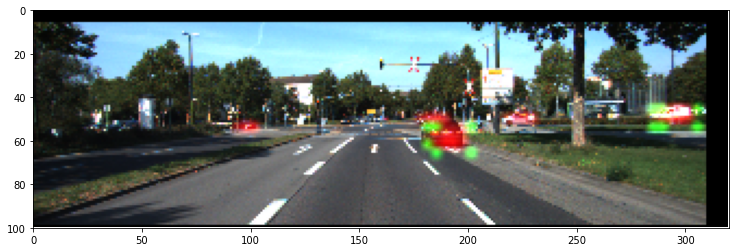

In [136]:
visualize_mask(img, mask, cnr)

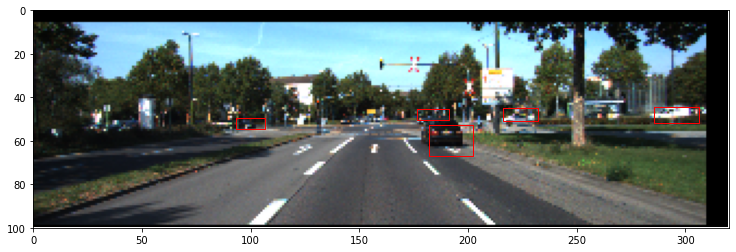

In [137]:
inference_2D(img, mask, regr, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


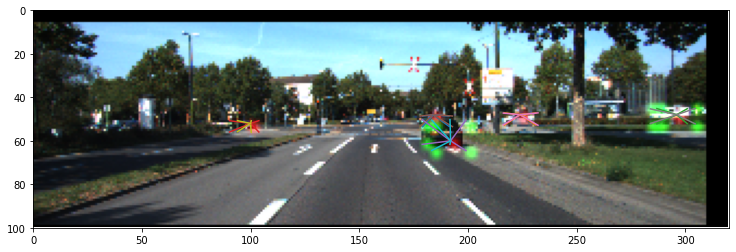

In [138]:
inference_3D(img, mask, regr_cnr, 4)

# 学習データ生成のためのclassを定義

# DL Model

In [56]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [57]:
class EfficientNet_(EfficientNet):
    
    def extract_features_midconv(self, inputs):
        out = []
        
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            y = block(x, drop_connect_rate=drop_connect_rate)
            if y.size()[-1] != x.size()[-1]:
                out.append(x)
            x = y
            
        x = self._swish(self._bn1(self._conv_head(x)))
        out.append(x)
        
        return out[1:]

In [58]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet_.from_pretrained('efficientnet-b0')
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 112, 256) # 1282 -> 1280
        self.up2 = up(256 + 40, 128)
        self.up3 = up(128 + 24, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x2, x3, x4, x5 = self.base_model.extract_features_midconv(x)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, x5.shape[2], x5.shape[3])
        x5 = torch.cat([x5, mesh2], 1)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.outc(x)
        return x

In [59]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cpu")
print(device)

cpu


# Check result
## なんかまあまあ推測できてる

In [60]:
model = MyUNet(20)
model.eval()
if torch.cuda.is_available():
    model_path = "../models/model.pth"
else:
    model_path = "../models/model_cpu.pth"
m_state_dict = torch.load(model_path)
model.load_state_dict(m_state_dict)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [146]:
val_dataset = CarDataset(val_list, annotations_list, PATH, training=False)
img = val_dataset[25]

output = model(torch.tensor(img[None]).to(device))
mask = output[0,0].detach().numpy()
regr = output[0,1:3].detach().numpy()
cnr = output[0,3].detach().numpy()
regr_cnr = output[0,4:].detach().numpy()

img = np.rollaxis(img, 0, 3)
regr = np.rollaxis(regr, 0, 3)
regr_cnr = np.rollaxis(regr_cnr, 0, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


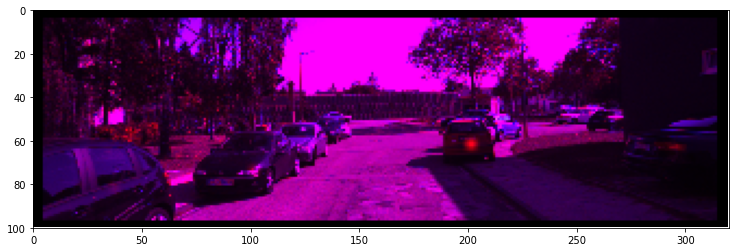

In [151]:
visualize_mask(img, mask, cnr)

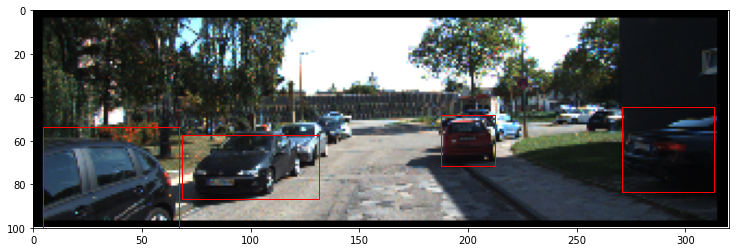

In [152]:
inference_2D(img, mask, regr, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


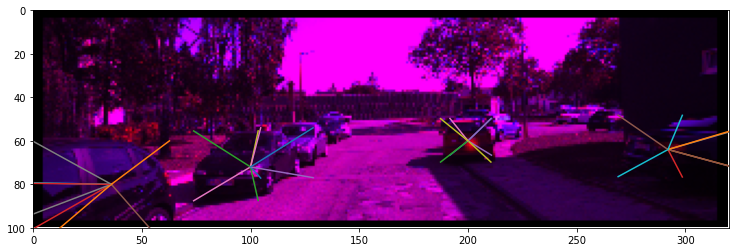

In [153]:
inference_3D(img, mask, regr_cnr, 4)

In [ ]:
img, mask, regr, cnr, regr_cnr = val_dataset[15]
img_np = np.rollaxis(img, 0, 3)*255
plt.figure(figsize=(15,8))
plt.imshow(img_np)

In [ ]:
output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

In [ ]:
output = model(torch.tensor(img[None]).to(device))
logits = output[0,2].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

# Detect Vehicle in 2D

In [ ]:
output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

logits_max = scipy.ndimage.filters.maximum_filter(logits, size=3)
detection = np.zeros_like(logits)
logits[logits_max!=logits] = 0
logits[logits<0] = 0
plt.figure(figsize=(15,8))
plt.imshow(logits)

In [ ]:
print("(y, x):", np.nonzero(logits))
print("confidence:", logits[logits!=0])
print("height:", output[0,1,logits!=0]*300)
print("width:", output[0,2,logits!=0]*300)

In [ ]:
plt.figure(figsize=(15, 4))
plt.imshow(img_np)

y, x = np.nonzero(logits)
conf = logits[logits!=0]
h = output[0,1,logits!=0].data.cpu().numpy()
w = output[0,2,logits!=0].data.cpu().numpy()

left = (x - w/2)*MODEL_SCALE
right = (x + w/2)*MODEL_SCALE
top = (y - h/2)*MODEL_SCALE
bottom = (y + h/2)*MODEL_SCALE

plt.plot([left,right,right,left,left],
         [top,top,bottom,bottom,top],
         color="r",linewidth=1
    )

# function for inference

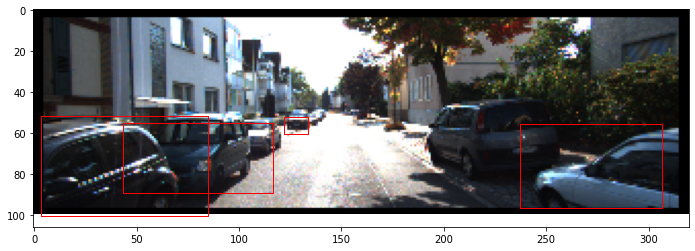

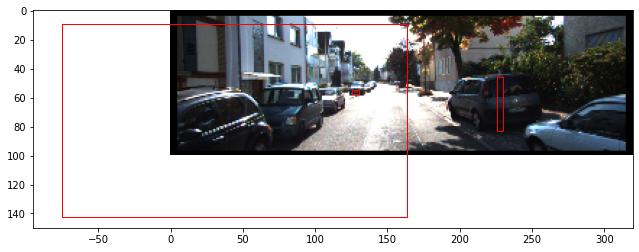

In [62]:
def inference_2D_waug(img):
    # 推論
    
    flip_lr_list = [0,0,1,1]
    flip_tb_list = [0,1,0,1]
    for i in range(4):
        flip_lr = 1 if flip_lr_list[i]==0 else -1
        flip_tb = 1 if flip_tb_list[i]==0 else -1
        img_fliped = img[:,::flip_tb,::flip_lr].copy()
        
        output = model(torch.tensor(img_fliped[None]).to(device)).detach().numpy()
        output[:,4:12] *= flip_lr
        output[:,12:] *= flip_tb
        try:
            outputs += output[:,:,::flip_tb,::flip_lr]
        except:
            outputs = output[:,:,::flip_tb,::flip_lr]
    output = outputs/4
    logits = output[0,0]
    
    # 検出した車両を抽出
    logits_max = scipy.ndimage.filters.maximum_filter(logits, size=3)
    detection = np.zeros_like(logits)
    logits[logits_max!=logits] = 0
    logits[logits<0] = 0
    
    # 検出結果をbounding boxに変換
    y, x = np.nonzero(logits)
    conf = logits[logits!=0]
    h = output[0,4,logits!=0]
    w = output[0,5,logits!=0]
    
    left = (x - w/2)*MODEL_SCALE
    right = (x + w/2)*MODEL_SCALE
    top = (y - h/2)*MODEL_SCALE
    bottom = (y + h/2)*MODEL_SCALE
    
    # 描画
    img_np = np.rollaxis(img, 0, 3)*255
    plt.figure(figsize=(15, 4))
    plt.imshow(img_np)
    plt.plot([left,right,right,left,left],
             [top,top,bottom,bottom,top],
             color="r",linewidth=1
    )

img = val_dataset[0]
inference_2D(img)
inference_2D_waug(img)